In [1386]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [1387]:
dfr=pd.read_csv('tempSiteRatings.csv')
dfd=pd.read_csv('tempUrlMetrics.csv')

In [1388]:
#print(dfd['slno'].values==dfr['id'].values)
dfd['rating']=dfr['rating']
dfd.to_csv('dataClf.csv')

In [1353]:
dataClf=pd.read_csv('dataClf.csv')
dataClf.drop(['Unnamed: 0'],1, inplace=True)
dataClf=dropMetrics(dataClf)
dataClf=changeColName(dataClf)

goodInd=np.argpartition(dataClf['rating'].values,-25)[-25:]
badInd=np.argpartition(dataClf['rating'].values,25)[:25]
allInd=np.concatenate((goodInd,badInd),axis=0)

dataClf['rating'][badInd]=0
dataClf['rating'][goodInd]=1
data=pd.DataFrame(dataClf[dataClf.columns].values[allInd],columns=dataClf.columns)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [1354]:
def changeColName(data):
    try:
        columns=['word_count','body_text_percent','emphasized_text_percent','text_position_changes','text_cluster_count','link_count','page_size','graphic_percent','graphic_count','colour_count','font_count','colourfulness','visual_complexity','rating']
        data.columns=columns
    except:
        columns=['word_count','body_text_percent','emphasized_text_percent','text_position_changes','text_cluster_count','link_count','page_size','graphic_percent','graphic_count','colour_count','font_count','colourfulness','visual_complexity']
        data.columns=columns
    return data

In [1355]:
def dropMetrics(data):
    try:
        data.drop(['id','url'],1, inplace=True)#,'p1','p2','p4','p6','p7','p10','p11','p12','p13'
    except:
        data.drop(['slno','url'],1, inplace=True)
    return data

In [1356]:
def stdNormal(data,mean,std):
    x = data.values #returns a numpy array
    columns=data.columns
    x_scaled=(x-mean)/std
    data=pd.DataFrame(x_scaled,columns=columns)
    return data

In [1357]:
def catCol(data,col):
    data[col+'_high']=np.zeros(data[col].shape)
    data[col+'_avg']=np.ones(data[col].shape)
    data[col+'_low']=np.zeros(data[col].shape)

    data[col+'_high'][np.where(data[col]>.431)[0]]=1.0
    data[col+'_avg'][np.where(data[col]>.431)[0]]=0.0
    data[col+'_avg'][np.where(data[col]<-.431)[0]]=0.0
    data[col+'_low'][np.where(data[col]<-.431)[0]]=1.0
    data.drop([col],1,inplace=True)
    return data

In [1358]:
def catColPdf(data,col):
    import scipy.stats
    
    mean_high=np.mean(data[col][np.where(data[col]>.431)[0]])
    std_high=np.std(data[col][np.where(data[col]>.431)[0]])


    mean_avg=np.mean(data[col][np.where(abs(data[col])<.431)[0]])
    std_avg=np.std(data[col][np.where(abs(data[col])<.431)[0]])

    mean_low=np.mean(data[col][np.where(data[col]<-.431)[0]])
    std_low=np.std(data[col][np.where(data[col]<-.431)[0]])

    data[col+'_high']=scipy.stats.norm(mean_high,std_high).pdf(data[col].values)
    data[col+'_avg']=scipy.stats.norm(mean_avg,std_avg).pdf(data[col].values)
    data[col+'_low']=scipy.stats.norm(mean_low,std_low).pdf(data[col].values)
    
    data.drop([col],1,inplace=True)
    
    return data


In [1359]:
def preProcess(data,mean,std):
    try:
        rating=data['rating']
        data.drop(['rating'],1,inplace=True)
    except:
        pass
    data=stdNormal(data,mean,std)
    data=catCol(data,'word_count')
    data=catCol(data,'page_size') 
    data=catCol(data,'colourfulness') 
    data=catCol(data,'visual_complexity') 
    try:
        data['rating']=rating
    except:
        pass
    return data

In [1360]:
irrCol=['emphasized_text_percent','font_count']
data.drop(irrCol,1,inplace=True)
mean=np.mean(data.values[:,:-1].astype(float),axis=0)
std=np.std(data.values[:,:-1].astype(float),axis=0)


In [1361]:
data=preProcess(data,mean,std)

In [1362]:
np.std(data.values.astype(float),axis=0)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.32496154, 0.49959984, 0.48      ,
       0.32496154, 0.4142463 , 0.3       , 0.46647615, 0.45825757,
       0.48538644, 0.46647615, 0.49355851, 0.43863424, 0.5       ])

In [1363]:
correlation = data.corr(method='pearson')
columns = correlation.nlargest(30,'rating').index
columns=np.sort(columns)

In [1364]:
columns=columns.tolist()
columns=pd.Index(columns)


In [1365]:
Y=data['rating'].values
X_temp=data[columns]
X_temp.drop(['rating'],1, inplace=True)
X=X_temp.values
columns=columns.drop('rating')

In [1366]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True,test_size=0.25, random_state=1)

In [1367]:
def LogClf():
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr')
    return clf

def DTClf():
    from sklearn.tree import DecisionTreeClassifier
    clf = DecisionTreeClassifier(random_state=0)
    return clf
def MLPClf():
    from sklearn.neural_network import MLPClassifier
    clf=MLPClassifier(hidden_layer_sizes=(20, ), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1)
    return clf
def NBClf():
    from sklearn.naive_bayes import GaussianNB
    clf=GaussianNB()
    return clf
def KNNClf():
    from sklearn.neighbors import KNeighborsClassifier
    clf=KNeighborsClassifier(n_neighbors=7)
    return clf
def getAccTest(clf):
    from sklearn.metrics import confusion_matrix
    Y_pred=clf.predict(X_test)
    return confusion_matrix(Y_test,Y_pred)
def getAccTrain(clf):
    from sklearn.metrics import confusion_matrix
    Y_pred=clf.predict(X_train)
    return confusion_matrix(Y_train,Y_pred)

In [1368]:
clfLog=DTClf()
clfLog.fit(X_train,Y_train)
try:
    for i in zip(columns.tolist(),clfLog.coef_.ravel()):
        print(i[0],'&','{0:.5f}'.format(i[1]),'\\\\')
except:
    print("error")

error


In [1369]:
columns

Index(['body_text_percent', 'colour_count', 'colourfulness_avg',
       'colourfulness_high', 'colourfulness_low', 'graphic_count',
       'graphic_percent', 'link_count', 'page_size_avg', 'page_size_high',
       'page_size_low', 'text_cluster_count', 'text_position_changes',
       'visual_complexity_avg', 'visual_complexity_high',
       'visual_complexity_low', 'word_count_avg', 'word_count_high',
       'word_count_low'],
      dtype='object')

In [1370]:
Y_pred=clfLog.predict(X_test)
from sklearn.metrics import precision_recall_fscore_support
precision,recall,fscore,_=precision_recall_fscore_support(Y_test, Y_pred)
param=[np.mean(precision),np.mean(recall),np.mean(fscore)]
param

[0.6375, 0.6833333333333333, 0.6388888888888888]

In [1371]:
print('Avg. Precision & ','{0:.5f}'.format(param[0]),'\\\\')
print('Avg. Recall &','{0:.5f}'.format(param[1]),'\\\\')
print('F-score & ','{0:.5f}'.format(param[2]),'\\\\')

Avg. Precision &  0.63750 \\
Avg. Recall & 0.68333 \\
F-score &  0.63889 \\


In [1372]:
getAccTest(clfLog),getAccTrain(clfLog)

(array([[7, 3],
        [1, 2]]), array([[15,  0],
        [ 0, 22]]))

In [1373]:
df={}
for year in range(2000,2020):
    df[str(year)]=pd.read_csv('yearMetrics/tempMpUrlMetrics'+str(year)+'.csv')
    df[str(year)]=dropMetrics(df[str(year)])
    df[str(year)]=changeColName(df[str(year)])
    irrCol=['emphasized_text_percent','font_count']
    df[str(year)].drop(irrCol,1,inplace=True)
    df[str(year)]=preProcess(df[str(year)],mean,std)
    



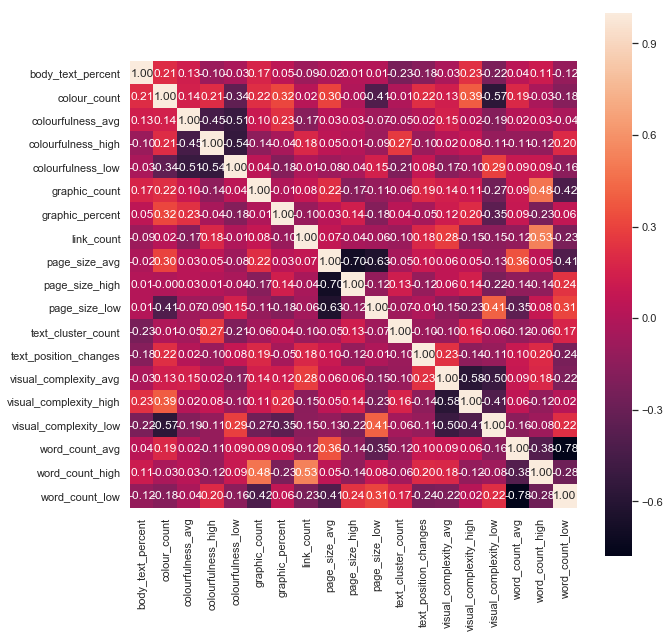

In [1374]:
fig, ax = plt.subplots(figsize=(10,10))    
correlation_map = np.corrcoef(data[columns].values.T)
sns.set(font_scale=1)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f',yticklabels=columns.values, xticklabels=columns.values)
plt.savefig('corr.png')
#plt.show()


In [1375]:
columns[1:]

Index(['colour_count', 'colourfulness_avg', 'colourfulness_high',
       'colourfulness_low', 'graphic_count', 'graphic_percent', 'link_count',
       'page_size_avg', 'page_size_high', 'page_size_low',
       'text_cluster_count', 'text_position_changes', 'visual_complexity_avg',
       'visual_complexity_high', 'visual_complexity_low', 'word_count_avg',
       'word_count_high', 'word_count_low'],
      dtype='object')

In [1376]:
year='2000'
np.where(clfLog.predict(df[str(year)][columns].values)>0)[0].shape[0]

13

In [1377]:
goodYears=np.zeros(20)
badYears=np.zeros(20)
for year in range(2000,2020):
    goodYears[year-2000]=np.where(clfLog.predict(df[str(year)][columns].values)>0)[0].shape[0]
    badYears[year-2000]=np.where(clfLog.predict(df[str(year)][columns].values)<=0)[0].shape[0]

In [1378]:
goodYears,badYears

(array([ 13.,  12.,   8.,   4.,  11.,  28.,  33.,  67.,  37., 116., 142.,
        122., 301., 341., 171., 195., 178., 128., 152., 142.]),
 array([ 97., 106., 120., 117., 109., 223., 216., 197.,  66., 151., 145.,
        113., 174., 142.,  88.,  77.,  66.,  32.,  59.,  51.]))

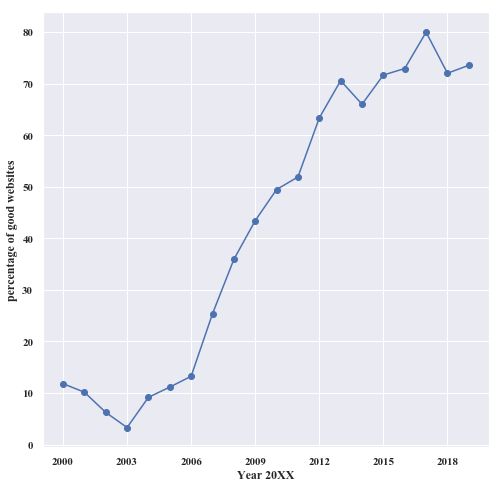

In [1385]:
fig, ax = plt.subplots(figsize=(8,8))
x=range(2000,2020)
y=(goodYears/(badYears+goodYears))*100
plt.errorbar(x, y, e, fmt='-o')
plt.xticks(np.arange(min(x), max(x)+1, 3))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 50
plt.ylabel('percentage of good websites')
plt.xlabel('Year 20XX')
plt.show()